# Apex Prototyping
This notebook Document a prototype workflow for using the Apex to conduct analysis. It aims to replicate the workflow as shown in the following figures:

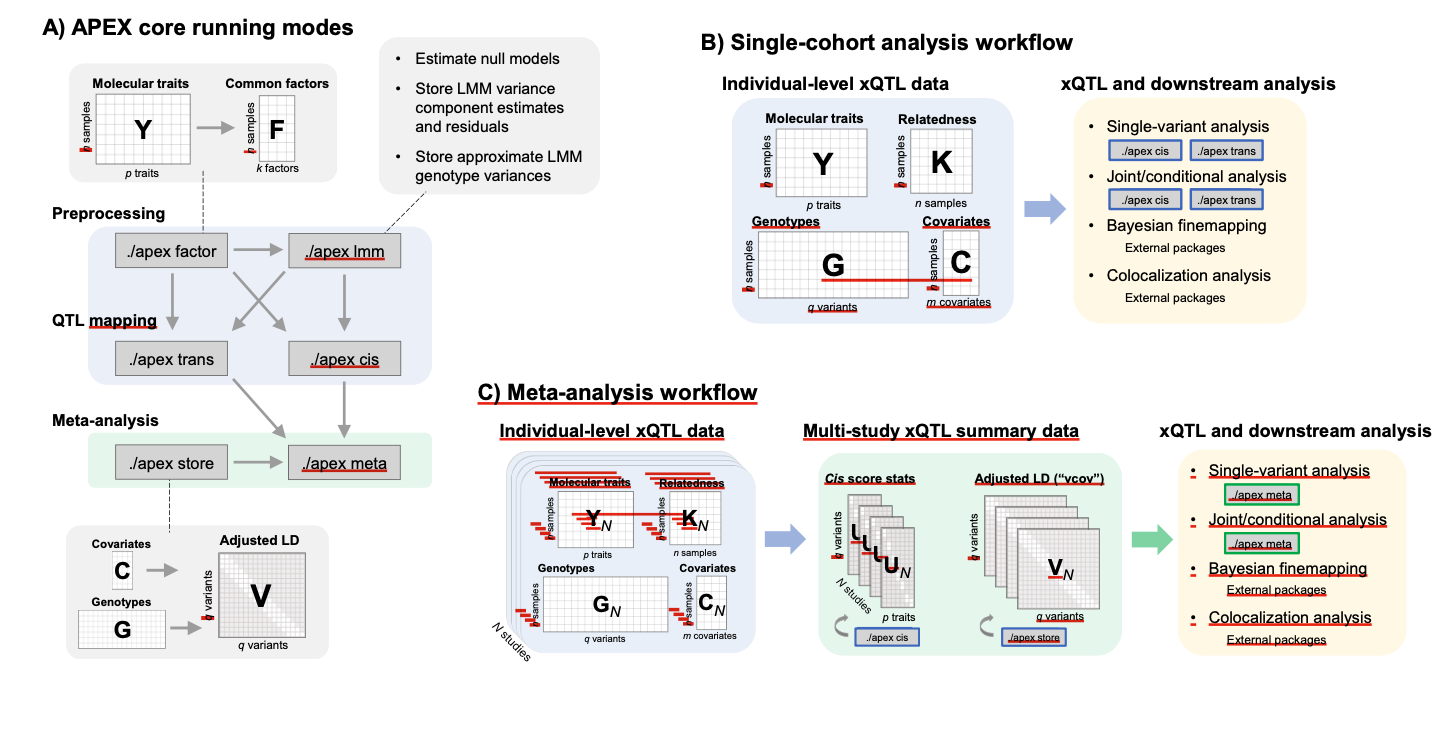

## Pre-requisites



# Input and Output
## Input
- `--molecular-pheno`, The text file containing the table describing the molecular phenotype. It shall have regions(genes) as rows and samples as columnes
- `--region_list` The text file with 4 columns specifying the #Chr, P0 (Start position), P1(End position) and names of regions to analyze. The name of the column is not important but the order of the columns. It is also important that the column name of the first column starts with a #. The region_list can can be generated by using another sos pipeline SOS_ROSMAP_gene_exp_processing.ipynb.

## Output


# Command interface 

In [ ]:
nohup sos run ~/GIT/neuro-twas/apex/Apex_prototyping.ipynb apex_cis \
  --molecular_pheno_whole  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /mnt/mfs/statgen/neuro-apex/pipeline_testing/ \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /mnt/mfs/statgen/neuro-apex/test_region \
  --iteration 2 \
  --container "" \
  --job_size 1 \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml &


# Working example


In [1]:
## Test pipeline with test data
## Switch back to abosolute path, otherwise there will be file not found error in step 5



ERROR: Failed to locate twas_fusion.ipynb.sos



# Global parameter settings
The section outlined the parameters that can be set in the command interface.

In [5]:
[global]
# Path to the input molecular phenotype data.
parameter: molecular_pheno_whole = path
# Covariate file, in similar format as the molecular_pheno
parameter: ori_covariate = ""
# List of Genotype file in plink trio format
parameter: genotype_list = path
# An index text file with 4 columns specifying the chr, start, end and names of regions to analyze
parameter: region_list = path
# Path to the work directory of the weight computation: output weights and cache will be saved to this directory.
parameter: wd = path('./')
# Path to store the output folder
parameter: output_path = f'{wd:a}/result'
# Specify the number of jobs per run.
parameter: job_size = 2
# Container option for software to run the analysis: docker or singularity
parameter: container = ''
# Prefix for the analysis output
parameter: Prefix = 'test'
# Path to the vcf file that act as a place holder
parameter: place_holder_vcf = path("/mnt/mfs/statgen/neuro-apex/mwe/data/ROSMAP_chr2.vcf.gz")

## Parameter to be used (TB
# Number of latent common factors
parameter: n_of_factor = 5
# Number of factor analysis iterations (0 for PCA).                                         
parameter: iteration = 0
# Factor analysis prior
parameter: p = 0.05
parameter: tau = 0.05


# Specify the scanning window for the up and downstream radius to analyze around the region of interest, in units of Kb
parameter: window = 100000


# Get regions of interest to focus on.
regions = [x.strip().split() for x in open(region_list).readlines() if x.strip() and not x.strip().startswith('#')]

geno_inventory = dict([x.strip().split() for x in open(genotype_list).readlines() if x.strip() and not x.strip().startswith('#')])

import os
def get_genotype_file(chrom, genotype_list, geno_inventory):
    chrom = f'{chrom}'
    if chrom.startswith('chr'):
        chrom = chrom[3:]
    if chrom not in geno_inventory:
        geno_file = f'{chrom}'
    else:
        geno_file = geno_inventory[chrom]
    if not os.path.isfile(geno_file):
        # relative path
        if not os.path.isfile(f'{genotype_list:ad}/' + geno_file):
            raise ValueError(f"Cannot find genotype file {geno_file}")
        else:
            geno_file = f'{genotype_list:ad}/' + geno_file
    return path(geno_file)

In [ ]:
[Expression_Filtering,apex_cis_1]
input: molecular_pheno_whole,region_list
output: molecular_pheno = f'{wd}/data/{Prefix}.mol_phe.bed.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = '4h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    pheno = read_delim("$[_input[0]]",delim = "\t")
    region = read_delim("$[_input[1]]",delim = "\t")
    output = inner_join(region, pheno , by = "gene_ID")
    output%>%write_delim("$[_output[0]:n]",delim = "\t")
  
bash: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container
    bgzip $[_output[0]:n] && tabix -p bed $[_output[0]]
  

In [ ]:
[Factor_analysis,apex_cis_2]
input:  output_from('Expression_Filtering'), covariate
output: factor_covariate = f'{wd:a}/data/{Prefix}.cov.gz'
parameter: threads = 3
task: trunk_workers = 1, trunk_size = job_size, walltime = '4h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    apex factor  \
    --out $[_output:nn] \
    --threads $[threads] \
    --iter $[iteration] \
    --cov $[_input[1]] \
    --factors $[n_of_factor] \
    --bed $[_input[0]] \
    --vcf $[place_holder_vcf]

## Partition of the molecular phenotype for each genes
This step extracts the molecular phenotype for each gene

In [ ]:
[Partition_1,apex_cis_3]
input: output_from('Expression_Filtering'), for_each = "regions"
output: f'{wd:a}/cache/{_input:bn}.{_regions[3]}.exp.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = '4h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
  
    # Get the line number for the region in the file
    line_num = system("awk '($$[region_name]==\"$[_regions[3]]\") {print NR}' $[_input]", intern=T)
    if (length(line_num) == 0){
      stop( "Cannot find $[_regions[3]] in column $[region_name]  $[_input]")}
    yi <- data.table::fread(file = $[_input:r], skip = as.integer(line_num) - 1, nrows = 1)
    samplenames_yi <- data.table::fread(file = $[_input:r], skip = 0, nrows = 1)
    colnames(yi) <- colnames(samplenames_yi)
    readr::write_tsv(yi, path = "$[_output[0]:n]", na = "NA", append = FALSE, col_names = TRUE, quote_escape = "double")
bash: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container
    bgzip $[_output[0]:n] && tabix -p bed $[_output[0]]

## Genotype Plink trio for each gene
Partition of the genotypes.

In [ ]:
[Partition_2,apex_cis_4]
input: group_by = 1, group_with = 'regions'
output: f'{_input[0]:n}.bed',
        f'{_input[0]:n}.bim',
        f'{_input[0]:n}.fam'

# look up for genotype file
geno_file = get_genotype_file(_regions[3],genotype_list,geno_inventory)

parameter: extract_snp = f'{geno_file:an}.bim'
parameter: exclude_snp = "./."
task: trunk_workers = 1, trunk_size = job_size, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    ##### Get the locus genotypes for $[_regions[3]]
    plink --bfile $[geno_file:an] \
    --make-bed \
    --out $[_output[0]:n] \
    --chr $[_regions[0]] \
    --from-bp $[int(_regions[1]) - window ] \
    --to-bp $[int(_regions[1]) + window ] \
    --extract $[extract_snp] \
    --exclude $[exclude_snp] \
    --allow-no-sex || true 
    
    
    touch $[_output]

## Convert the plink trio into VCF

In [ ]:
[Partition_3,apex_cis_5]
input: group_by = 1, group_with = 'regions'
output: f'{_input[0]:n}.vcf.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    plink --bfile $[_inpunt:an] \
    --recode vcf-iid     \
    --out $[_output[0]:n]
    bgzip $[_output[0]:n]
    tabix -p vcf $[_output[0]]
    tabix -H  $[_output[0]]
    touch $[_output]

## Null GRM Generation
This step generate a grm with 0 kinship

In [ ]:
[GRM_G]
input: molecular_pheno
output: f'{wd:n}/data/GRM_default.txt'
task: trunk_workers = 1, trunk_size = job_size, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    mol_phe = read_delim("$[_input]",delim = "\t")
    grm = tibble(sample_1 = colnames(mol_phe)[5:ncol(mol_phe)])
    grm = grm%>%mutate(sample_2 = map(sample_1, ~grm$sample_1))%>%unnest(sample_2)%>%mutate(kinship = map2_dbl(sample_1,sample_2,~.x==.y))%>%select(`#id1` = sample_1, "id2" = sample_2,kinship )
    grm%>%write_delim("$[_output]",delim = "\t")

## LMM Regression  
This step are done to precompute and store a) LMM null models and trait residuals and b) spline terms for LMM genotypic variances to speed up downstream analysis

In [ ]:
[LMM,apex_cis_7]
input: output_from(['Partition_1','Partition_3','GRM_G'])
parameter: threads = 3
parameter: window = 100000
output: f'{_input[0]:n}.lmm_resid.bed.gz',
        f'{_input[0]:n}.theta.gz'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    apex lmm --vcf $[_input[1]] \
    --bed $[_input[0]] \
    --cov $[factor_covariate] \
    --out $[_input[0]:n] \
    --threads $[threads] \
    --grm $[_input[2]] \
    --fit-null \
    --save-resid \
    --write-gvar \
    --window $[window]
    

## QTL Sumstat generation  
This step generate the cis-QTL summary statistics and vcov (covariate-adjusted LD) files for downstream analysis from summary statistics. The analysis is done per chromosome to reduce running time.

In [ ]:
[cis,apex_cis_8]
input: output_from(['Partition_1','Partition_3']),output_from(['LMM'])[1]
output: f'{wd:a}/cis/{Prefix}.{_regions[3]}.cis_gene_table.txt.gz',
        f'{wd:a}/cis/{Prefix}.{_regions[3]}.cis_sumstats.txt.gz',
        f'{wd:a}/cis/{Prefix}.{_regions[3]}.cis_long_table.txt.gz'
        
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    apex cis --vcf $[_input[1]] \
    --bed $[_input[0]] \
    --cov $[covariate] \
    --out $[_output[0]:nnn] \
    --threads $[threads] \
    --theta-file  $[_input[2]]\
    --window $[window]

## Conducting meta analysis for multi-variant(TBD) 


